In [115]:
import pandas as pd
import numpy as np

In [133]:
n400 = pd.read_csv("N400_by_trial.csv")
p600 = pd.read_csv("P600_by_trial.csv")
spr = pd.read_csv("SPR_by_trial.csv")

In [169]:
def extract_features(dataframe: pd.DataFrame, condition):
    """
    Extracts features from a dataframe of ERPs / SRP's. 
    
    Args:
        dataframe: A dataframe of ERPs / SRP's.
        condition: The condition to extract features from.
    Returns:
        A numpy array of features.
    """
    
    features = dataframe[dataframe["Condition"] == condition]
    features = features.drop(["Condition"], axis=1)
    features = features.set_index("ItemNum")
    features = np.expand_dims(features.to_numpy(), axis=0)
    return features

n400_control = extract_features(n400, "control")
n400_script_related = extract_features(n400, "script-related")
n400_script_unrelated = extract_features(n400, "script-unrelated")

p600_control = extract_features(p600, "control")
p600_script_related = extract_features(p600, "script-related")
p600_script_unrelated = extract_features(p600, "script-unrelated")

spr_control = extract_features(spr, "control")
spr_script_related = extract_features(spr, "script-related")
spr_script_unrelated = extract_features(spr, "script-unrelated")

### Visualise data

In [175]:
def print_item(item = 0):
    print(f"ItemNum: {item+1}")
    print(f"ERP's (n400): \n{n400_control[0][item]}")
    print(f"SPR: {spr_control[0][item]}")

print_item(0)

ItemNum: 1
ERP's (n400): 
[-1.79205279 -1.86712636 -1.70394696 -3.9231718  -4.74066061 -4.90966067
 -2.37030723 -1.98819744 -3.95095261 -3.93343971 -4.15195217 -2.20787836
 -3.72650287 -2.34174259  0.50864363 -1.46534323 -2.34354867 -2.66679243
 -0.31249529  0.80925981 -1.85934109 -1.26222229 -1.31437606 -1.49421967
 -0.46220971 -0.38511491]
SPR: [432.36363636]


In [200]:
# check data shape
print(spr_control.shape)
print(n400_control.shape)
print(p600_control.shape)

# check data type
print(type(spr_control))
print(n400_control.dtype)
print(p600_control.dtype)

(1, 90, 1)
(1, 90, 26)
(1, 90, 26)
<class 'numpy.ndarray'>
float64
float64


### Prepare data for training

In [153]:
from sklearn.model_selection import train_test_split

In [220]:
X = np.concatenate((n400_control, p600_control), axis=0)
y = np.reshape(spr_control, (90, 1, 1))

# reshape x to have 90 in first dimension
X = np.reshape(X, (90, X.shape[0], 26))

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [222]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (72, 2, 26)
y_train shape: (72, 1, 1)


### Helpers

In [295]:
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

get_custom_objects().update({"r_squared": r_squared})

In [407]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_r_squared', patience=20)

### Construct RNN Model

In [99]:
# from tensorflow import Sequential
from keras import layers, Sequential

In [411]:
# make an rnn model that takes in the n400 and p600 data and predicts the spr data

model = Sequential()
model.add(layers.Input(shape=(2, 26)))
model.add(layers.LSTM(32, input_shape=(2, 26)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="relu"))

model.compile(optimizer="adam", loss="mae", metrics=['mae', 'mse', 'r_squared'])

model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_89 (LSTM)              (None, 32)                7552      
                                                                 
 dense_209 (Dense)           (None, 64)                2112      
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_210 (Dense)           (None, 128)               8320      
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_211 (Dense)           (None, 256)               33024     
                                                                 
 dropout_44 (Dropout)        (None, 256)             

In [415]:
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 0s 204ms/step - loss: 366.5010 - mae: 366.5010 - mse: 143017.2969 - r_squared: -17.2178 - val_loss: 318.1191 - val_mae: 318.1191 - val_mse: 116686.8984 - val_r_squared: -8.5642
Epoch 2/200
1/1 [==============================] - 0s 105ms/step - loss: 353.3212 - mae: 353.3212 - mse: 134126.8125 - r_squared: -16.0853 - val_loss: 295.8369 - val_mae: 295.8369 - val_mse: 104217.2891 - val_r_squared: -7.5422
Epoch 3/200
1/1 [==============================] - 0s 105ms/step - loss: 328.6880 - mae: 328.6880 - mse: 118588.4219 - r_squared: -14.1060 - val_loss: 267.9755 - val_mae: 267.9755 - val_mse: 90232.1719 - val_r_squared: -6.3959
Epoch 4/200
1/1 [==============================] - 0s 92ms/step - loss: 311.9436 - mae: 311.9436 - mse: 108086.5547 - r_squared: -12.7683 - val_loss: 232.9806 - val_mae: 232.9806 - val_mse: 75208.6562 - val_r_squared: -5.1645
Epoch 5/200
1/1 [==============================] - 0s 108ms/step - loss: 278.7485 - mae: 27

### Test model

In [337]:
from sklearn.metrics import mean_squared_error, r2_score

In [416]:
pred = model.predict(X_test)

# remove 1 dim from y_test to match pred
y_test_ = np.squeeze(y_test, axis=1)
pred = np.squeeze(pred, axis=1)

mse = mean_squared_error(y_test_, pred)
print(f"\nMSE: {mse}")

r_squared = r2_score(y_test_, pred)
print(f"R^2: {r_squared}")

print("\nFirst 5 predictions: ")
for i in range(min(len(pred), 5)):
    print(f"pred: {round(pred[i])}", end=" ")
    print(f"actual: {round(y_test_[i])}")

1/1 [==============================] - 0s 33ms/step

MSE: 6963.37805559529
R^2: -0.06579668643618652

First 5 predictions: 
pred: 411 actual: 595
pred: 407 actual: 428
pred: 292 actual: 425
pred: 447 actual: 472
pred: 442 actual: 432


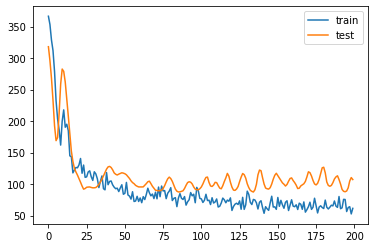

In [417]:
# plot history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
